# Personalized Medicine: Redefining Cancer Treatment
## A kaggle data exploration
## About the data set:
### Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

### Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

### For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

### We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.


### the kernel on kaggle: https://www.kaggle.com/sousablde/breast-cancer-mutation-effect-on-oncogenecity/edit/run/18611091

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import math
import re
import time
import warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nltk.corpus import stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score, accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from imblearn.over_sampling import SMOTE

from collections import Counter, defaultdict

from scipy.sparse import hstack

from sklearn.ensemble import RandomForestClassifier

from mlxtend.classifier import StackingClassifier

## Loading the data files

In [2]:
#training_variants is a comma separated file
training_variants_df = pd.read_csv(r"C:\Users\sousa\Desktop\github\Redefining Cancer Treatment\training_variants\training_variants.csv")

#training_text is separated by // delimeter
training_text_df = pd.read_csv(r"C:\Users\sousa\Desktop\github\Redefining Cancer Treatment\training_text\training_text.csv", sep = "\|\|", engine = "python", names = 
                              ["ID", "TEXT"], skiprows = 1)

In [3]:
#checking the first rows for training variants
training_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### There are 4 fields in the table:
#### -ID: links mutation to clinical evidence
#### -Gene: nomenclature for the gene that carries identified variation
#### -Variation: changed aa in the gene
#### -Class: classification of the variant based on documented papers

In [4]:
#checking the shape of the data for training_Variants
training_variants_df.shape

(3321, 4)

#### there are 3321 rows and 4 columns (ID, gene, variation and class)

In [5]:
#getting info from the file
training_variants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


#### it looks like there are no missing values

In [6]:
#checking the first rows for training_text
training_text_df.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


#### The ID will be common between the 2 data files I started working on 

In [7]:
#getting info from training_text
training_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


#### TEXT column seems to be missing a few values (ID has 3321 and Text has 3316)

### We are attempting to predict the cancer class based on this data but how many classes are there described in these datasets?

In [8]:
training_variants_df.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

#### there are 9 classes of genetic mutations
#### since it these are discrete values we might consider this problem a classification problem
#### within the classification problems it is not binary since we can have more than one output, so this would be a good candidate in my opinion to a multiclass classification problem

### Starting by processing all the text data

In [9]:
#removing the stop words from the text, I will be using the natural language toolkit to help me
stop_words = set(stopwords.words('english'))

In [10]:
#create a function to preprocess it
def data_preprocess(input_text, ind, col):
    #remove int values from the text data
    if type(input_text) is not int:
        string = ""
        #replacing special characters with space
        input_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(input_text))
        #replacing multiple spaces with single space
        input_text = re.sub('\s+', ' ', str(input_text))
        #make all lower case
        input_text = input_text.lower()
        
        for word in input_text.split():
            #keep everything but the stop words
            if not word in stop_words:
                string += word + " "
        
        training_text_df[col][ind] = string

In [11]:
for index, row, in training_text_df.iterrows():
    if type(row['TEXT']) is str:
        data_preprocess(row['TEXT'], index, 'TEXT')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Merging the 2 dataframes to simplify all the preprocessing that is needed to be done, make id of training_variant_df match training_text_df

In [12]:
training_merged = pd.merge(training_variants_df, training_text_df,on="ID",how = 'left')
training_merged.head()


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


#### Looking for missing values

In [13]:
#since I am checking along the columns I will pass axis = 1
training_merged[training_merged.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


#### Doing imputation to deal with the missing values, combining gene and variation columns

In [14]:
training_merged.loc[training_merged['TEXT'].isnull(), 'TEXT'] = training_merged['Gene'] + ' ' + training_merged['Variation']

#### rechecking for missing values

In [15]:
training_merged[training_merged.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,TEXT


### Data training, testing and validation
#### the data will be divided between training set, cross-validation set and test set 
#### the train set will help building the model, the cross-validation will be used to tune the hyper-parameters and refine the model, the test will be untouch 

In [16]:
#making sure the columns gene and variation have no spaces in them, replacing them with underscore
y_real = training_merged['Class'].values
training_merged.Gene = training_merged.Gene.str.replace('\s+', '_')
training_merged.Variation = training_merged.Variation.str.replace('\s+', '_')

## train-test-split

In [17]:
#splitting data into test set
X_train, x_test, y_train, y_test = train_test_split(training_merged, y_real, stratify = y_real, test_size = 0.2)

#splitting the data into training set
X_train, x_crossval, y_train, y_crossval = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2)


In [18]:
print('Data points in X_train: ', X_train.shape[0])
print('Data points in x_test: ', x_test.shape[0])
print('Data points in cross-val: ', x_crossval.shape[0])

Data points in X_train:  2124
Data points in x_test:  665
Data points in cross-val:  532


In [19]:
#checking how data was distributed
train_class_distributed = X_train['Class'].value_counts().sort_index()
test_class_distributed = x_test['Class'].value_counts().sort_index()
crossval_class_distributed = x_crossval['Class'].value_counts().sort_index()

In [20]:
for a, b, c in zip(train_class_distributed, test_class_distributed, crossval_class_distributed):
    print(a, b, c)

363 114 91
289 91 72
57 18 14
439 137 110
155 48 39
176 55 44
609 191 153
12 4 3
24 7 6


#### based on the numbers of the distributed sets it seems like there aren't a lot in class 8(12-4-3) and class 9(24, 7, 6) but that might be just because there are less entries overall

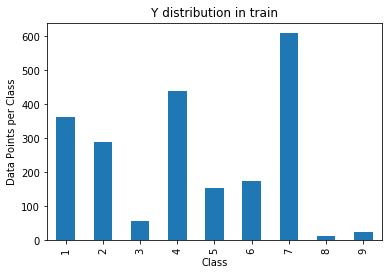

In [21]:
#visualizing the distribution
train_class_distributed.plot(kind = 'bar')

plt.xlabel('Class')
plt.ylabel('Data Points per Class')
plt.title('Y distribution in train')
plt.show()

In [22]:
#checking the distribution per percentage of data in the classes
sorted_y = np.argsort(-train_class_distributed.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',train_class_distributed.values[i], '(', np.round((train_class_distributed.values[i]/X_train.shape[0]*100), 3), '%)')

n_data_points = []
n_class = []
percent_data = []
for i in sorted_y:
    n_class.append(i+1)
    n_data_points.append(train_class_distributed.values[i])
    percent_data.append(np.round((train_class_distributed.values[i]/X_train.shape[0]*100), 3))


Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


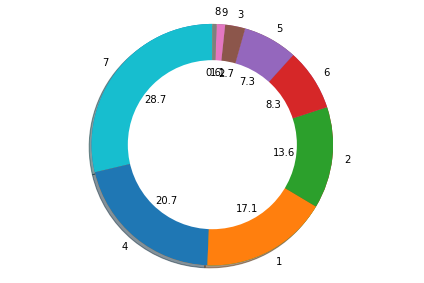

In [23]:
#plotting the results for the distribution
figureObject, axesObject = plt.subplots()
axesObject.pie(percent_data, labels = n_class, autopct='%1.1f', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
wedges, texts = plt.pie(percent_data, shadow=True, startangle=90)
axesObject.axis('equal')
plt.tight_layout()
plt.show()

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


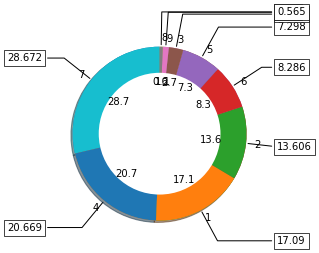

In [24]:
#checking the distribution per percentage of data in the classes, trying to get fancy with my graphs, failing but still feeling pretty proud lol
#need to come back to this after I am not saturated of looking at it
sorted_y = np.argsort(-train_class_distributed.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',train_class_distributed.values[i], '(', np.round((train_class_distributed.values[i]/X_train.shape[0]*100), 3), '%)')

n_data_points = []
n_class = []
percent_data = []
for i in sorted_y:
    n_class.append(i+1)
    n_data_points.append(train_class_distributed.values[i])
    percent_data.append(np.round((train_class_distributed.values[i]/X_train.shape[0]*100), 3))


figureObject, axesObject = plt.subplots()
axesObject.pie(percent_data, labels = n_class, autopct='%1.1f', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
wedges, texts = plt.pie(percent_data, shadow=True, startangle=90)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate(percent_data[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


### According to kaggle the submissions are evaluated based on Multi class log loss between predicted probability and the observed target

In [25]:
#I need to generate 9 random numbers (because we have 9 classes) and their sum should total 9 (again, 9 classes) so 
#the overall probability can total 1
test_len = x_test.shape[0]
crossval_len = x_crossval.shape[0]

In [26]:
#creating an output array with the same size as the data I am using for cross validation
y_predicted_crossval = np.zeros((crossval_len, 9))

for i in range (crossval_len):
    rand_probab = np.random.rand(1,9)
    y_predicted_crossval[i] = ((rand_probab/sum(sum(rand_probab)))[0])

print ("Log loss on the cross validation data using random model", log_loss(y_crossval, y_predicted_crossval, eps = 1e-15))

Log loss on the cross validation data using random model 2.5803848597594645


In [27]:
#checking for the error in the test set
#creating an output array again
y_predicted_test = np.zeros((test_len, 9))

for i in range(test_len):
    rand_probab = np.random.rand(1,9)
    y_predicted_test[i] = ((rand_probab/sum(sum(rand_probab)))[0])
    
print ("Log loss on the test data using random model", log_loss(y_test, y_predicted_test, eps = 1e-15))

Log loss on the test data using random model 2.523649516650363


In [28]:
#using argmax to find the maximum probability 
y_predicted = np.argmax(y_predicted_test, axis = 1)

In [29]:
#check the output, should be 600 and something values
y_predicted

array([6, 2, 2, 6, 2, 3, 7, 6, 2, 0, 5, 8, 0, 6, 3, 5, 2, 0, 3, 3, 4, 6,
       0, 0, 7, 6, 3, 3, 3, 4, 1, 2, 7, 1, 0, 0, 2, 4, 3, 3, 5, 2, 7, 7,
       1, 4, 4, 2, 6, 8, 3, 0, 5, 0, 0, 4, 3, 1, 5, 5, 2, 6, 1, 1, 5, 0,
       3, 5, 0, 1, 0, 2, 2, 0, 5, 1, 1, 4, 1, 8, 4, 8, 2, 1, 0, 3, 8, 4,
       1, 0, 1, 6, 5, 0, 4, 3, 5, 3, 2, 4, 6, 5, 4, 5, 4, 7, 1, 2, 5, 7,
       4, 7, 0, 1, 6, 1, 8, 2, 4, 7, 8, 4, 6, 3, 6, 7, 1, 6, 0, 5, 6, 5,
       4, 7, 1, 0, 5, 1, 2, 8, 7, 6, 5, 6, 2, 1, 1, 5, 7, 2, 8, 7, 0, 3,
       4, 5, 4, 6, 7, 0, 7, 3, 0, 6, 2, 2, 4, 6, 8, 2, 3, 7, 3, 5, 0, 1,
       2, 1, 1, 1, 1, 8, 8, 8, 2, 4, 5, 5, 1, 8, 8, 0, 4, 6, 2, 3, 4, 3,
       7, 5, 0, 3, 4, 1, 0, 0, 6, 6, 7, 7, 5, 7, 4, 2, 7, 6, 4, 2, 1, 8,
       4, 7, 1, 8, 1, 6, 1, 4, 4, 8, 5, 0, 6, 2, 1, 5, 1, 6, 5, 4, 8, 5,
       0, 0, 2, 7, 1, 1, 8, 7, 4, 5, 0, 5, 3, 3, 7, 8, 0, 7, 2, 2, 0, 1,
       0, 7, 1, 3, 2, 4, 1, 8, 3, 7, 0, 1, 5, 4, 2, 5, 1, 7, 4, 4, 2, 4,
       3, 8, 6, 7, 7, 6, 3, 1, 2, 4, 8, 7, 4, 0, 6,

In [30]:
#the index on the previous output seemed to start at 0, let's correct it so it matches the classes proposed on the 
#problem statement
y_predicted = y_predicted + 1
y_predicted

array([7, 3, 3, 7, 3, 4, 8, 7, 3, 1, 6, 9, 1, 7, 4, 6, 3, 1, 4, 4, 5, 7,
       1, 1, 8, 7, 4, 4, 4, 5, 2, 3, 8, 2, 1, 1, 3, 5, 4, 4, 6, 3, 8, 8,
       2, 5, 5, 3, 7, 9, 4, 1, 6, 1, 1, 5, 4, 2, 6, 6, 3, 7, 2, 2, 6, 1,
       4, 6, 1, 2, 1, 3, 3, 1, 6, 2, 2, 5, 2, 9, 5, 9, 3, 2, 1, 4, 9, 5,
       2, 1, 2, 7, 6, 1, 5, 4, 6, 4, 3, 5, 7, 6, 5, 6, 5, 8, 2, 3, 6, 8,
       5, 8, 1, 2, 7, 2, 9, 3, 5, 8, 9, 5, 7, 4, 7, 8, 2, 7, 1, 6, 7, 6,
       5, 8, 2, 1, 6, 2, 3, 9, 8, 7, 6, 7, 3, 2, 2, 6, 8, 3, 9, 8, 1, 4,
       5, 6, 5, 7, 8, 1, 8, 4, 1, 7, 3, 3, 5, 7, 9, 3, 4, 8, 4, 6, 1, 2,
       3, 2, 2, 2, 2, 9, 9, 9, 3, 5, 6, 6, 2, 9, 9, 1, 5, 7, 3, 4, 5, 4,
       8, 6, 1, 4, 5, 2, 1, 1, 7, 7, 8, 8, 6, 8, 5, 3, 8, 7, 5, 3, 2, 9,
       5, 8, 2, 9, 2, 7, 2, 5, 5, 9, 6, 1, 7, 3, 2, 6, 2, 7, 6, 5, 9, 6,
       1, 1, 3, 8, 2, 2, 9, 8, 5, 6, 1, 6, 4, 4, 8, 9, 1, 8, 3, 3, 1, 2,
       1, 8, 2, 4, 3, 5, 2, 9, 4, 8, 1, 2, 6, 5, 3, 6, 2, 8, 5, 5, 3, 5,
       4, 9, 7, 8, 8, 7, 4, 2, 3, 5, 9, 8, 5, 1, 7,

#### Confusion matrix usage to evaluate the quality of the output of a classifier

In [31]:
C = confusion_matrix(y_test, y_predicted)

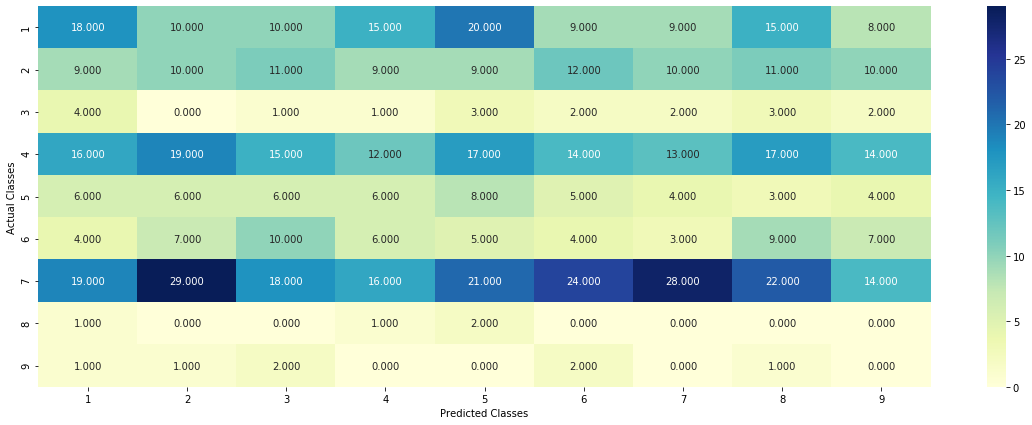

In [32]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize = (20,7))
sb.heatmap(C, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()

#### Based on this heatmap the prediction algorithm is pretty bad, I'll take a quick look on the precision matrix

In [33]:
B = (C/C.sum(axis = 0))

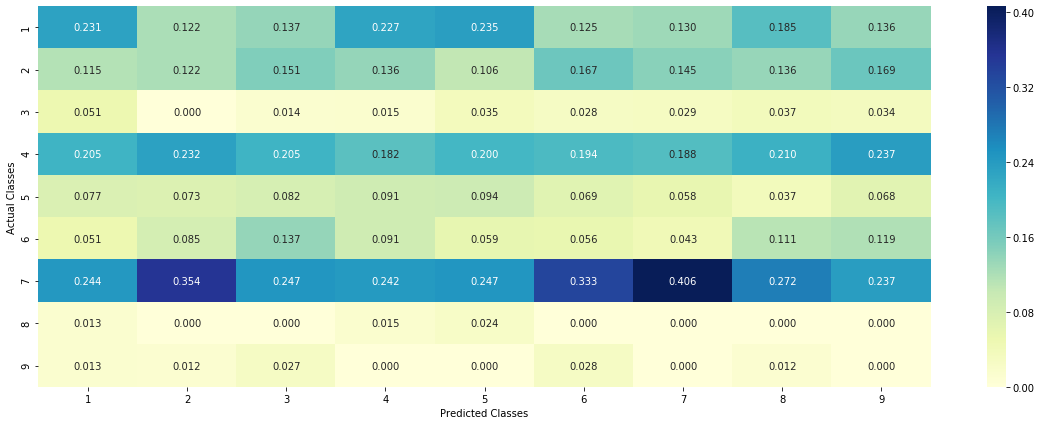

In [34]:
plt.figure(figsize = (20,7))
sb.heatmap(B, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()

#### precision is the number of correct results divided by the number of all returned results, looking at the values obtained in this matric it is pretty clear that we have pretty bad precision based on this model

### To check the Recall matrix: recall is the number of correct results divided by the number of results that should have been returned.

In [35]:
A =(((C.T)/(C.sum(axis=1))).T)

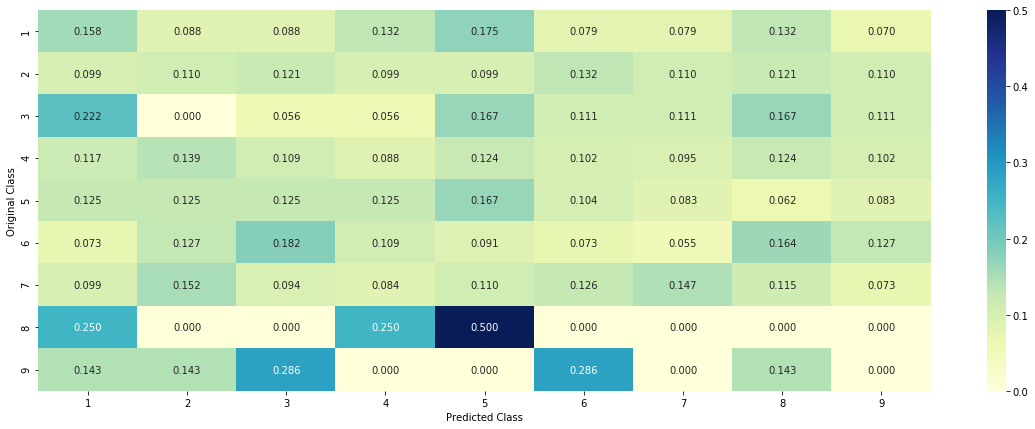

In [36]:
plt.figure(figsize=(20,7))
sb.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### again the results are pretty poor

### The next step is to manipulate some of the data that we have in our columns, as a reminder, there were 3 independent columns (gene, variation and text) in the data set and one independent column (the classes)

#### at the moment the gene column is in the format of categorical data 
#### checking how many unique genes appear in the data and how many times each gene appears

In [37]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes: ', unique_genes.shape[0])
print (unique_genes.head(10))

Number of Unique Genes:  230
BRCA1     156
TP53      103
EGFR      101
BRCA2      81
PTEN       80
KIT        56
BRAF       54
ALK        45
PDGFRA     42
ERBB2      41
Name: Gene, dtype: int64


#### Making a cumulative distribution plot

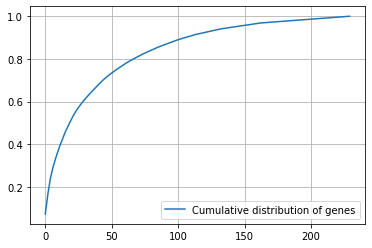

In [38]:
s = sum(unique_genes.values)
h = (unique_genes.values/s)
c = np.cumsum(h)
plt.plot(c, label = "Cumulative distribution of genes")
#plt.ylim(0, 1.0)
#plt.xlim(0, 200)
plt.grid()
plt.legend()
plt.show()

#### my distribution plot is having serious issues considering that I am not even reaching 20% contribution for the first 200 values->corrected this, distribution plot looks a bit better now

### Converting the categorical variable 
#### 2 ways to approach it: one-hot encoding and response encoding (mean imputation)
#### what we will be looking at is how impactful a gene is to predict a particular class 

#### the problem with one-hot encoding is that it makes the data sparse by creating far too many columns if the dataset is very large (response encoding is a way to deal with this)
#### in response encoding instead of creating many columns for every row we will create just the columns with the probabilities of each particular gene belonging to a particular class (in this case it would be 9)

In [39]:
#one-hot encoding of the Gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
crossval_gene_feature_onehotCoding = gene_vectorizer.transform(x_crossval['Gene'])

train_gene_feature_onehotCoding.shape

(2124, 230)

#### what is observed when calling shapes is that many columns appeared as the number of unique genes

In [40]:
#name of the columns after one-hot encoding
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'i

#### the way it will look like with response encoding is as follow:
#### alpha: laplace smoothing
#### feature: gene, variation
#### df: X_train, x_test, x_crossval
#### make a vector in which:
##### -first element: number of times it occured in a clasa +10*alpha / n of times it occured in the data + 90*alpha 
##### -gv_dict: look up table for stored values 
##### -gv_fea: for the training data

#### one of the tools used is laplace smoothing, with laplace smoothing the goal is to increase the zero probability values to a small positive number [and correspondingly reduce other values so that the sum is still 1]. Since we are multiplying probabilities, having a probability of 0 can greatly throw off our calculations.

In [41]:
# get_gv_fea_dict: Get Gene variation Feature Dictionary
def get_gv_fea_dict(alpha, feature, df):

    value_count = X_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):

            cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

In [42]:
# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = X_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])

    return gv_fea

In [43]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_crossval))

In [44]:
train_gene_feature_responseCoding.shape

(2124, 9)

### The question now should be how good is Gene to predict the classes?
### Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.
#### Stochastic gradient descent considers only 1 random point while changing weights unlike gradient descent which considers the whole training data

# Calibrated classifier
### Predicted probabilities that match the expected distribution of probabilities for each class are referred to as calibrated. The problem is, not all machine learning models are capable of predicting calibrated probabilities. A classifier can be calibrated in scikit-learn using the CalibratedClassifierCV class. There are two ways to use this class: prefit and cross-validation. You can fit a model on a training dataset and calibrate this prefit model using a hold out validation dataset.

In [45]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [46]:
#now to implementing a logistic regression using an sgd classifier and the calibrated classifier
#I will be using Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function.

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    y_predicted = sig_clf.predict_proba(crossval_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))
    

For values of alpha =  1e-05 The log loss is: 1.2127280579881645
For values of alpha =  0.0001 The log loss is: 1.1814478120521121
For values of alpha =  0.001 The log loss is: 1.2137546605743181
For values of alpha =  0.01 The log loss is: 1.3423109578998067
For values of alpha =  0.1 The log loss is: 1.456519816291274
For values of alpha =  1 The log loss is: 1.4995811839156432


#### for each alpha we got a different log loss and the difference between them is not very big.
#### the smallest log-loss was For values of alpha =  0.0001 The log loss is: 1.2490817935971195
#### so this is the alpha I will be using from now on

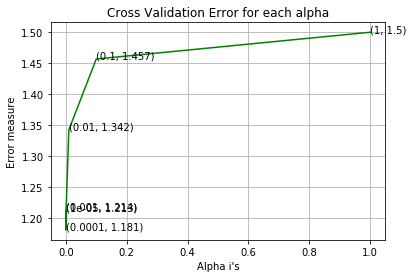

In [47]:
#I will make a visual check for the alphas
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [48]:
#now to use the best alpha to compute the log-loss
best_alpha = np.argmin(cv_log_error_array)


clf = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

y_predicted = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('best alpha = ', alpha[best_alpha], " train log loss :",log_loss(y_train, y_predicted, labels=clf.classes_, eps=1e-15))
y_predicted = sig_clf.predict_proba(crossval_gene_feature_onehotCoding)
print('best alpha = ', alpha[best_alpha], " cross validation log loss :",log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))
y_predicted = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('best alpha = ', alpha[best_alpha], " test log loss :",log_loss(y_test, y_predicted, labels=clf.classes_, eps=1e-15))


best alpha =  0.0001  train log loss : 0.980266848096523
best alpha =  0.0001  cross validation log loss : 1.1814478120521121
best alpha =  0.0001  test log loss : 1.185359870085446


#### now regarding the stability of this model: if the overlap between the genes in the train and in the test set is low (and the crossval set) the model will not be very stable and that is something we also want to test

In [49]:
test_coverage=x_test[x_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=x_crossval[x_crossval['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_crossval.shape[0],":" ,(cv_coverage/x_crossval.shape[0])*100)

1. In test data 646 out of 665 : 97.14285714285714
2. In cross validation data 513 out of  532 : 96.42857142857143


In [50]:
from wordcloud import WordCloud
#from matplotlib_venn import venn
import matplotlib_venn as venn2
from matplotlib_venn import venn2
#from matplotlib_venn_wordcloud import venn3_wordcloud
train_items = pd.unique(X_train['Gene'])
test_items = pd.unique(x_test['Gene'])
crossval_items = pd.unique(x_crossval['Gene'])

in_train_test = set(test_items).intersection(set(train_items))
in_train_crossval = set(crossval_items).intersection(set(train_items))
in_test_crossval = set(crossval_items).intersection(set(test_items))

only_train = set(train_items).difference(set(test_items))
only_train2 = set(train_items).difference(set(crossval_items))
exclusive_train = set(only_train).difference(set(only_train2))

only_test = set(test_items).difference(set(train_items))
only_test2 = set(test_items).difference(set(crossval_items))
exclusive_test = set(only_test).difference(set(only_test2))

only_crossval = set(crossval_items).difference(set(train_items))
only_crossval2 = set(crossval_items).difference(set(test_items))
exclusive_crossval = set(only_crossval).difference(set(only_crossval2))

#quick print out to check if things make sense
print("Items in train: ", len(train_items), " Overlap train-test: ", len(in_train_test), " Overlap train-crossval: ",
      len(in_train_crossval), " Exclusive to train: ", len(exclusive_train))


Items in train:  230  Overlap train-test:  145  Overlap train-crossval:  121  Exclusive to train:  19


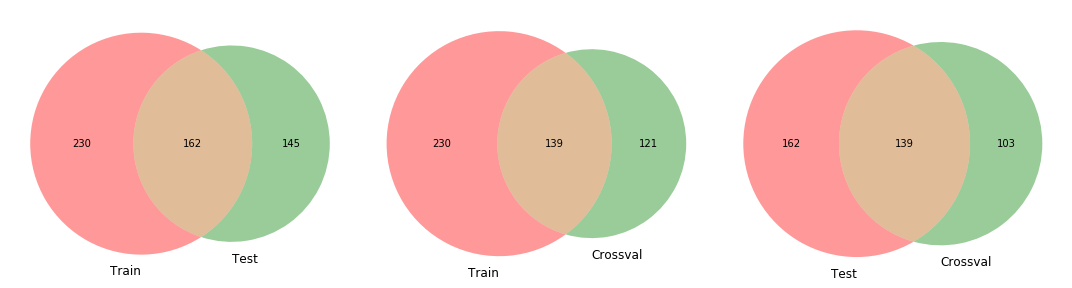

Unique genes in train:  85  Unique genes in test:  17
Unique genes in train:  109  Unique genes in crossval:  18


In [51]:
figure, axes = plt.subplots(1, 3, figsize = (15,15), squeeze = False)
#overlap between train and test
v = venn2(subsets = (len(train_items), len(in_train_test), len(test_items)), 
      set_labels=('Train', 'Test'), ax = axes[0][0]);


#overlap between train and crossval
v2 = venn2(subsets = (len(train_items), len(in_train_crossval), len(crossval_items)), 
      set_labels=('Train', 'Crossval'), ax = axes[0][1]);

#overlap between test and crossval
v2 = venn2(subsets = (len(test_items), len(in_test_crossval), len(crossval_items)), 
      set_labels=('Test', 'Crossval'), ax = axes[0][2]);

plt.tight_layout()
plt.show()

print('Unique genes in train: ', len(only_train), ' Unique genes in test: ', len(only_test))
print('Unique genes in train: ', len(only_train2), ' Unique genes in crossval: ', len(only_crossval))

### Now to evaluate the effect of the variation column

Number of variations:  1949
Truncating_Mutations    58
Deletion                44
Amplification           33
Fusions                 23
Q61L                     3
T58I                     3
R841K                    2
S308A                    2
F384L                    2
Q209L                    2
Name: Variation, dtype: int64


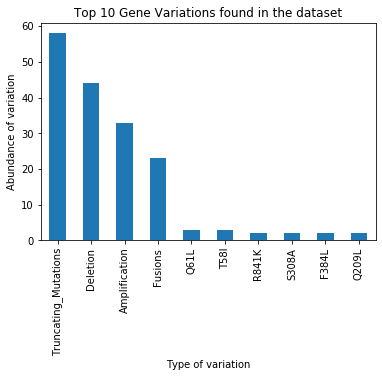

In [52]:
unique_variations = X_train['Variation'].value_counts()
print('Number of variations: ', unique_variations.shape[0])

print(unique_variations.head(10))
#most abundant variations visualization
unique_variations.head(10).plot(kind = 'bar')

plt.xlabel('Type of variation')
plt.ylabel('Abundance of variation')
plt.title('Top 10 Gene Variations found in the dataset')
plt.show()


### Based on the current knowledge of Biology it is not surprising that Truncations, deletions,  amplifications, fusions and overexpressions are the most abundant since these are extremely function altering, but looking further into the other possible columns I would seem like there are some rogue classifications (like the last bar in the plot seems to also be a fusion, but, since it is appended to the actual specific type of fusion it is falling into a category by itself. I wonder if there is something I could do about cleaning things further more and harmonize the variation types.

In [53]:
#I will take a further look at the gene variation classifications
unique_variations.head(30)

Truncating_Mutations    58
Deletion                44
Amplification           33
Fusions                 23
Q61L                     3
T58I                     3
R841K                    2
S308A                    2
F384L                    2
Q209L                    2
T73I                     2
E542K                    2
E17K                     2
M1R                      2
K117N                    2
G12D                     2
T167A                    2
Q61H                     2
A146T                    2
P130S                    2
G12V                     2
Overexpression           2
G12C                     2
R631C                    1
Q252H                    1
F1245V                   1
R267Q                    1
G1770V                   1
D1280V                   1
L844R                    1
Name: Variation, dtype: int64

#### It looks like it was just the one single case for the fusion nomenclature and the remaining variations seem to be in particular base pairs for the gene sequence that lead to aa swaps

[0.02730697 0.0480226  0.06355932 ... 0.99905838 0.99952919 1.        ]


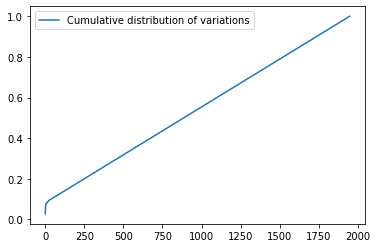

In [54]:
#Looking at the distribution of the variations
s = sum(unique_variations.values)
h = unique_variations.values/s
c = np.cumsum(h)
print(c)
plt.plot(c,label = 'Cumulative distribution of variations')
plt.legend()
plt.show()


### looking at the graph we can see the contribution of those more abundant types of variations and after that the contributions are very small

#### so follwing up with one-hot encoding

In [55]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_crossval['Variation'])

train_variation_feature_onehotCoding.shape

(2124, 1981)

#### looks like there are almost as many variations as there are genes

#### following up with response encoding

In [56]:
# alpha is used for laplace smoothing
alpha = 1
# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_train))
# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_test))
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_crossval))

train_variation_feature_responseCoding.shape

(2124, 9)

In [57]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [58]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    y_predicted = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.70981085577648
For values of alpha =  0.0001 The log loss is: 1.6957745913604323
For values of alpha =  0.001 The log loss is: 1.698344599375859
For values of alpha =  0.01 The log loss is: 1.7140241836173318
For values of alpha =  0.1 The log loss is: 1.7304307235122047
For values of alpha =  1 The log loss is: 1.7324721096384568


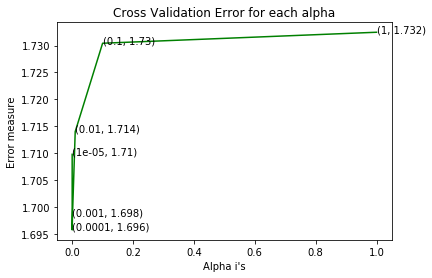

In [59]:
# pltotting to select best alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [60]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

y_predicted = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predicted, labels=clf.classes_, eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))
y_predicted = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predicted, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.7628597370844139
For values of best alpha =  0.0001 The cross validation log loss is: 1.6957745913604323
For values of best alpha =  0.0001 The test log loss is: 1.697850490543162


### And again looking at the stability to check how many of the targets were correctly predicted

In [61]:
test_coverage=x_test[x_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=x_crossval[x_crossval['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

In [62]:
print('1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_crossval.shape[0],":" ,(cv_coverage/x_crossval.shape[0])*100)

1. In test data 73 out of 665 : 10.977443609022556
2. In cross validation data 70 out of  532 : 13.157894736842104


### well, that is pretty bad which means that the variation feature is not very stable, odd since the log-loss is low and pretty decent 

### Initiating the evaluation of the text column

In [63]:
#starting with a function to count each word in the text
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [64]:
#test if a particular key was already found in the dictionary

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [65]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data

text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53367


In [66]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class

for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data

total_dict = extract_dictionary_paddle(X_train)

In [67]:
confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

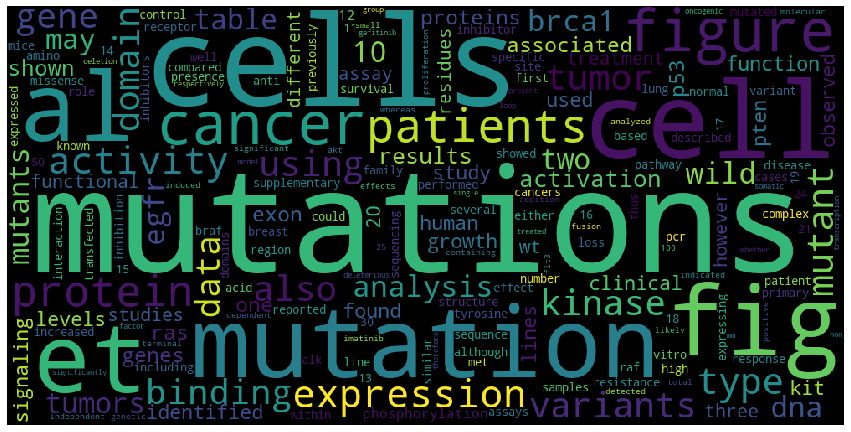

In [68]:
from collections import Counter
word_could_dict=Counter(text_fea_dict)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### looking at the word cloud it seems like many of the most abundant words are related to methodology and not the juice of the paper itself, I wonder if this exercise was limited to just the article conclusions if we could be more successful, many references to figure names, egfr can be used as a growth factor for tissue culture, 'also', 'et' and 'previously' probably refer to other authors citations (this would be hard to tackle since each publisher has their own citation format, mentions of kits (probably extractions and electophoresis) still, pretty cool to see

#### very awesome to see p53 and BRCA and pten appear as top words considering that they are some very well described genes

#### just spotted ras as well

#### also tiny appearence of gifitinib which is an EGFR inhibitor and common cancer drug

In [69]:
#response coding the text features

train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_crossval)

In [70]:
#converting row values so they can have a total sum of 1

train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [71]:
#normalizing all my features

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


test_text_feature_onehotCoding = text_vectorizer.transform(x_test['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)


cv_text_feature_onehotCoding = text_vectorizer.transform(x_crossval['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [72]:
#we will sort the dictionaries by value (or at least their representation, dictionaries are orderless)

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

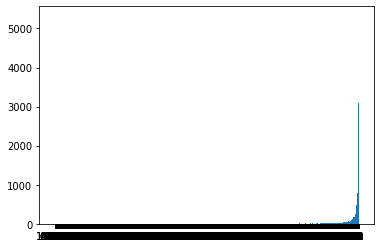

In [73]:
#and now to plot the frequencies
#c = Counter(sorted_text_occur)

labels, values = zip(*Counter(sorted_text_occur).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

#### the intention was good but obviously there are far too many words with differing frequencies to make this a visually appealing plot

### Now to actually work on the model using just the text feature

In [74]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    y_predicted = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.2986685423394058
For values of alpha =  0.0001 The log loss is: 1.1797469438542834
For values of alpha =  0.001 The log loss is: 1.2082970741711783
For values of alpha =  0.01 The log loss is: 1.3076090062449004
For values of alpha =  0.1 The log loss is: 1.428902623850762
For values of alpha =  1 The log loss is: 1.6328432595619726


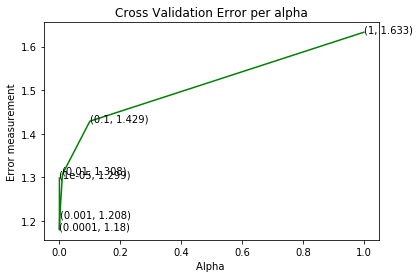

In [75]:
#and to proceed to the visualization of the cross-validation error for each alpha:

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.title("Cross Validation Error per alpha")
plt.xlabel("Alpha ")
plt.ylabel("Error measurement")
plt.show()

In [76]:
#using the best alpha:

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

y_predicted = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predicted, labels=clf.classes_, eps=1e-15))
y_predicted = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_crossval, y_predicted, labels=clf.classes_, eps=1e-15))
y_predicted = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predicted, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.6890296212926111
For values of best alpha =  0.0001 The cross validation log loss is: 1.1797469438542834
For values of best alpha =  0.0001 The test log loss is: 1.2014359726850832


In [77]:
#now to check how much overlap there is between text data

def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [78]:
len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of words from test that appear in the train set")
len1,len2 = get_intersec_text(x_crossval)
print(np.round((len2/len1)*100, 3), "% of words from Cross Validation that appear in the train set")

97.624 % of words from test that appear in the train set
97.643 % of words from Cross Validation that appear in the train set


#### these are great values way over 90%

### Preparing the data for the ML portion of the analysis 

In [79]:
# creating a function to return the log-loss
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [80]:
#function to plot the confusion matrix for y and y^
#Y hat (written ŷ ) is the predicted value of y (the dependent variable) in a regression equation. 
#It can also be considered to be the average value of the response variable.

def plot_confusion_matrix(test_y, y_predicted):
    C = confusion_matrix(test_y, y_predicted)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sb.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sb.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sb.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


In [81]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    predicted_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((predicted_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, predicted_y)
    

In [82]:
def mis_class_datapoints(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    predicted_y = sig_clf.predict(test_x)
    log_loss(test_y, sig_clf.predict_proba(test_x))
    m_class = np.count_nonzero((predicted_y- test_y))/test_y.shape[0]
    return m_class

In [83]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### And now to combine all 3 features

In [84]:
# merging gene, variance and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((crossval_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(x_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
crossval_y = np.array(list(x_crossval['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [85]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55578)
(number of data points * number of features) in test data =  (665, 55578)
(number of data points * number of features) in cross validation data = (532, 55578)


In [86]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# ML- Naive Bayes model


In [87]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i) # as is requested for the classification
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(crossval_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(crossval_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.2807134327481096
for alpha = 0.0001
Log Loss : 1.2792118735084386
for alpha = 0.001
Log Loss : 1.2809177175558832
for alpha = 0.1
Log Loss : 1.3015233936827164
for alpha = 1
Log Loss : 1.3103326320303745
for alpha = 10
Log Loss : 1.4235631278023482
for alpha = 100
Log Loss : 1.4155232473822557
for alpha = 1000
Log Loss : 1.3387435547633642


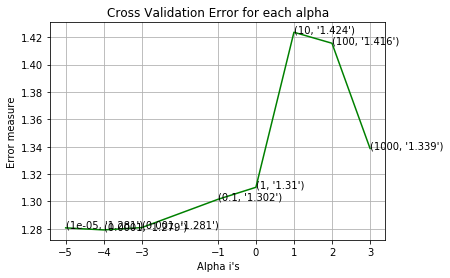

In [88]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### we will use the best alpha to proceed with the model (minimum value for log-loss)

In [89]:
best_alpha = np.argmin(cv_log_error_array)
nb_alpha = alpha[best_alpha]

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
nb_train_ll_OH = (log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
nb_cv_ll_OH = (log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15))
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
nb_test_ll_OH = (log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.8199577797228285
For values of best alpha =  0.0001 The cross validation log loss is: 1.2792118735084386
For values of best alpha =  0.0001 The test log loss is: 1.2628987428556313


#### If there is a very large difference in log-loss between train and test, which is a sign that this is just overfitted to hell
#### The stuff here is pretty acceptable

Log Loss : 1.2792118735084386
# missclassified points : 0.40037593984962405
-------------------- Confusion matrix --------------------


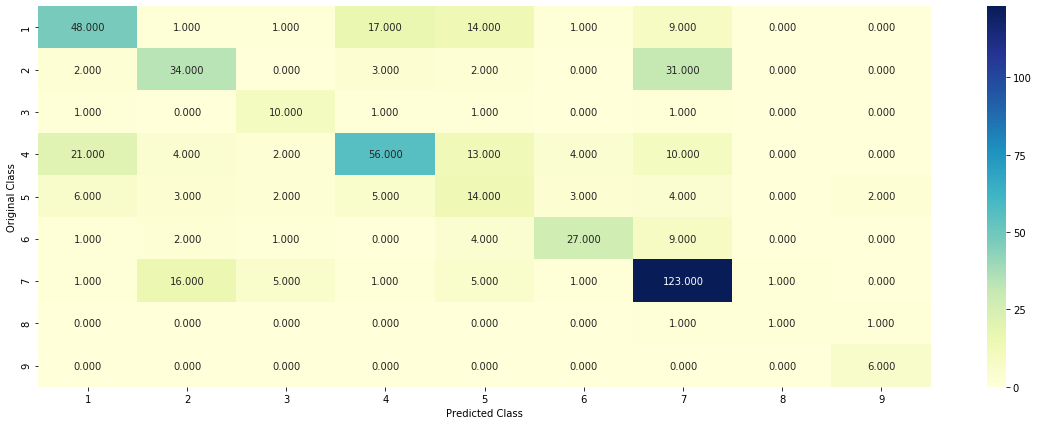

-------------------- Precision matrix (Columm Sum=1) --------------------


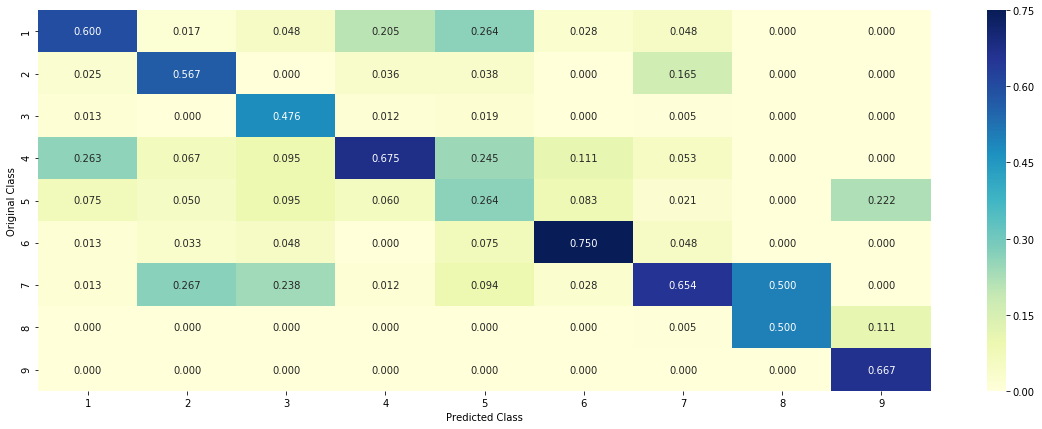

-------------------- Recall matrix (Row sum=1) --------------------


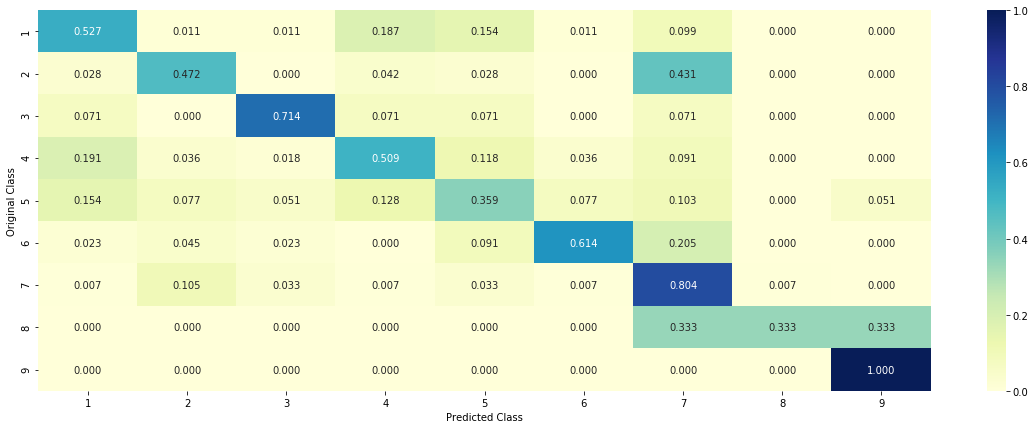

In [90]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(crossval_y, sig_clf_probs))
nb_misclass_OH = np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- crossval_y))/crossval_y.shape[0]
print("# missclassified points :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- crossval_y))/crossval_y.shape[0])
plot_confusion_matrix(crossval_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### looking at the confusion matrix the diagonal values should have better values, note also the missclassified points, subtracting this to 1 would give us the actual accuracy of the model

#### the precision matrix looks better but still not getting values of 1

#### the recall matrix shows the same trend 

### Interpreting the model

#### One of the things required for this data set case was that we should have some answers on why the model is predicting things the way it is, the impfeature_names is one of the defined functions that names the most relevant features by name 

In [91]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5964 0.0844 0.0096 0.1088 0.0382 0.0385 0.1149 0.0049 0.0043]]
Actual Class : 1
--------------------------------------------------
12 Text feature [affect] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feature [type] present in test data point [True]
15 Text feature [protein] present in test data point [True]
16 Text feature [one] present in test data point [True]
18 Text feature [wild] present in test data point [True]
20 Text feature [amino] present in test data point [True]
21 Text feature [two] present in test data point [True]
23 Text feature [dna] present in test data point [True]
24 Text feature [therefore] present in test data point [True]
25 Text feature [four] present in test data point [True]
26 Text feature [acids] present in test data point [True]
27 Text feature [likely] present in test data point [True]
28 Text feature [loss] present in test data point [True]
2

#### unfortunately many of these are just filler words
#### the class that shows the highest probability is class 4 by quite a difference

#### checking another data point 

In [92]:
test_point_index = 50
no_feature = 50
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.1021 0.1032 0.0117 0.133  0.4511 0.047  0.1406 0.006  0.0053]]
Actual Class : 4
--------------------------------------------------
6 Text feature [assays] present in test data point [True]
7 Text feature [cooccurrence] present in test data point [True]
8 Text feature [variants] present in test data point [True]
9 Text feature [neutral] present in test data point [True]
11 Text feature [align] present in test data point [True]
12 Text feature [functional] present in test data point [True]
13 Text feature [uncertain] present in test data point [True]
18 Text feature [gvgd] present in test data point [True]
19 Text feature [article] present in test data point [True]
20 Text feature [nhgri] present in test data point [True]
21 Text feature [agvgd] present in test data point [True]
23 Text feature [v1736a] present in test data point [True]
24 Text feature [evolutionarily] present in test data point [True]
27 Text feature [c65] present i

### Naive Bayes performs decently for this data set but, lets see what KNN brings to the table

# KNN

In [93]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(crossval_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(crossval_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.0987829114286871
for alpha = 11
Log Loss : 1.0960733651920276
for alpha = 15
Log Loss : 1.0947614086587538
for alpha = 21
Log Loss : 1.1158295146854185
for alpha = 31
Log Loss : 1.1080169680801177
for alpha = 41
Log Loss : 1.1159616864434407
for alpha = 51
Log Loss : 1.1227311294832827
for alpha = 99
Log Loss : 1.142960806417137


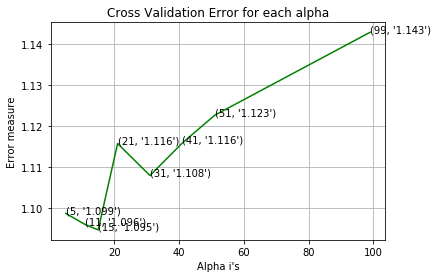

In [94]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [95]:
best_alpha = np.argmin(cv_log_error_array)
knn_alpha = alpha[best_alpha]
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
knn_train_ll_RE = log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
knn_cv_ll_RE = log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
knn_test_ll_RE = log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  15 The train log loss is: 0.7157496870289306
For values of best alpha =  15 The cross validation log loss is: 1.0947614086587538
For values of best alpha =  15 The test log loss is: 1.0500311785301524


Log loss : 1.0947614086587538
Number of mis-classified points : 0.40977443609022557
-------------------- Confusion matrix --------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


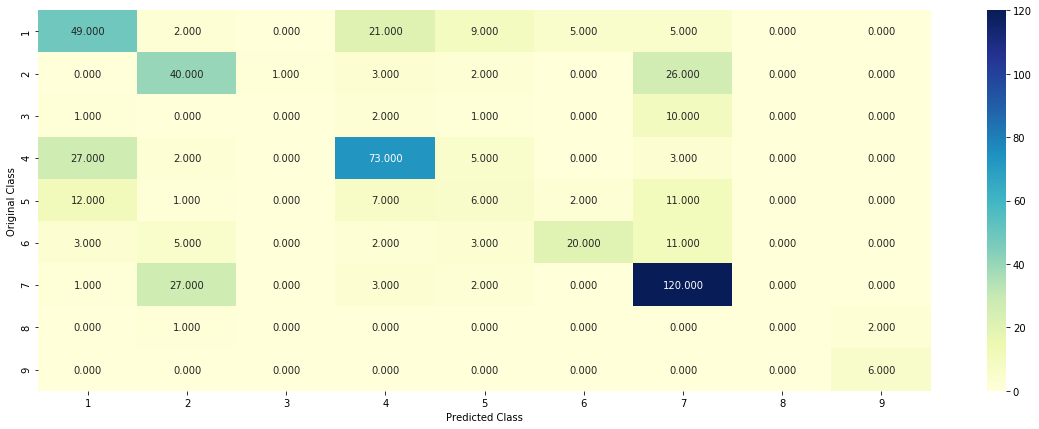

-------------------- Precision matrix (Columm Sum=1) --------------------


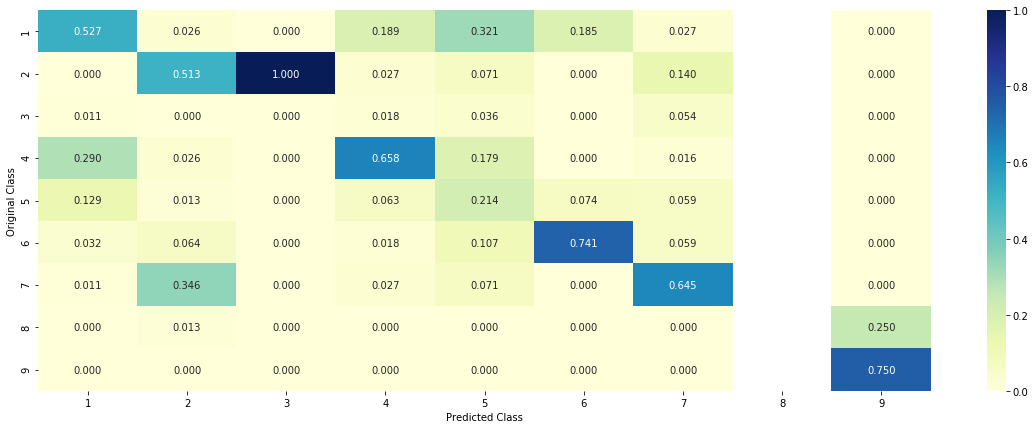

-------------------- Recall matrix (Row sum=1) --------------------


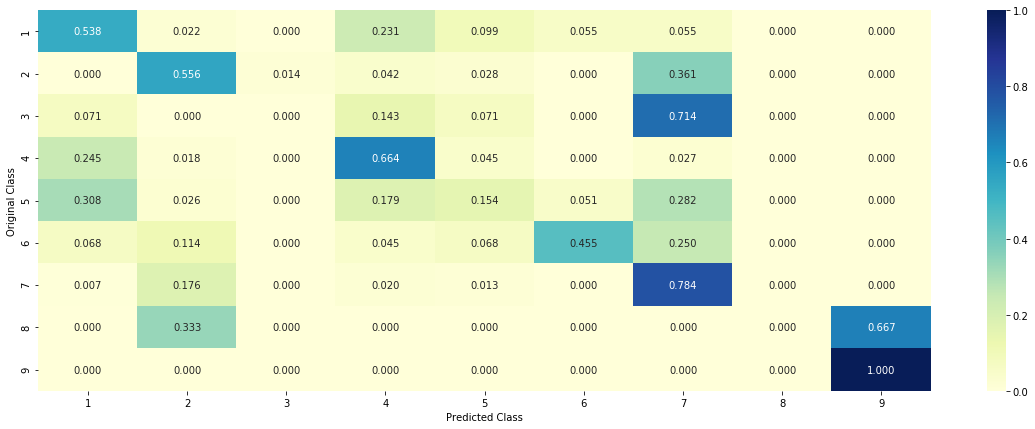

In [96]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, crossval_y, clf)
knn_misclass = mis_class_datapoints(train_x_responseCoding, train_y, cv_x_responseCoding, crossval_y, clf)

In [97]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 1
The  15  nearest neighbours of the test points belongs to classes [1 4 1 1 4 4 4 4 1 1 4 4 5 4 4]
Fequency of nearest points : Counter({4: 9, 1: 5, 5: 1})


In [98]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
k value for knn is 15 and the nearest neighbours of the test points belongs to classes [7 2 8 4 1 4 2 2 2 9 2 8 8 6 2]
Fequency of nearest points : Counter({2: 6, 8: 3, 4: 2, 7: 1, 1: 1, 9: 1, 6: 1})


# Logistic Regression
### there is going to be a degreee of oversampling because some classes are more represented in terms of data
### class 8 and class 9 had very little data

#### balancing all the classes and how the dataset will look like
#### using one-hot encoding as before since we can word with high-dimensional data

In [99]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(crossval_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(crossval_y, sig_clf_probs)) 


for alpha = 1e-06


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packag

Log Loss : 1.3388303976600164
for alpha = 1e-05


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


Log Loss : 1.3124404348983227
for alpha = 0.0001
Log Loss : 1.150797552922712
for alpha = 0.001
Log Loss : 1.1254789689162499
for alpha = 0.01
Log Loss : 1.2177709583360765
for alpha = 0.1
Log Loss : 1.4738097800847876
for alpha = 1
Log Loss : 1.703503124550467
for alpha = 10
Log Loss : 1.7316810645551912
for alpha = 100
Log Loss : 1.7345789410816856


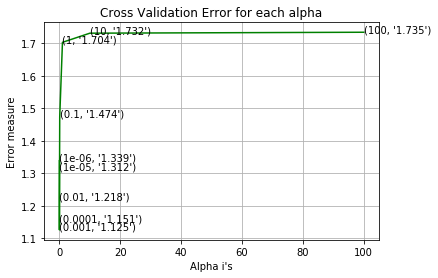

In [100]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [101]:
best_alpha = np.argmin(cv_log_error_array)
LR_bal_alpha = alpha[best_alpha]
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predicted_y = sig_clf.predict_proba(train_x_onehotCoding)
LR_bal_train_ll_OH = log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(cv_x_onehotCoding)
LR_bal_cv_ll_OH = log_loss(crossval_y, predicted_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(crossval_y, predicted_y, labels=clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(test_x_onehotCoding)
LR_bal_test_ll_OH = log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.543197549160305
For values of best alpha =  0.001 The cross validation log loss is: 1.1254789689162499
For values of best alpha =  0.001 The test log loss is: 1.067986153067199


### log-losses are not too different from what we got in the previous models

Log loss : 1.1254789689162499
Number of mis-classified points : 0.35714285714285715
-------------------- Confusion matrix --------------------


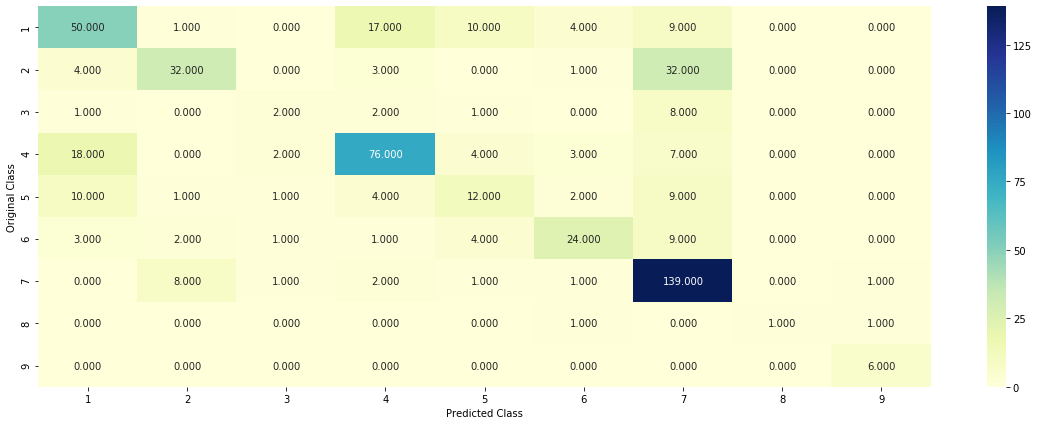

-------------------- Precision matrix (Columm Sum=1) --------------------


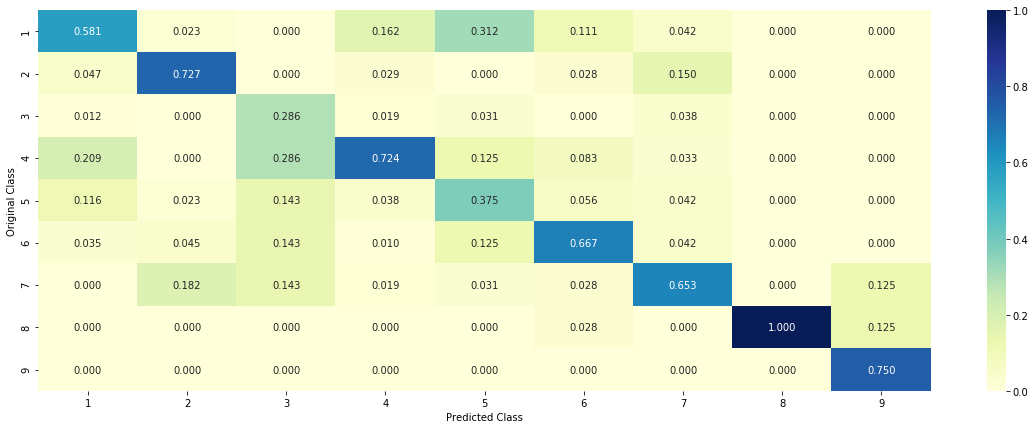

-------------------- Recall matrix (Row sum=1) --------------------


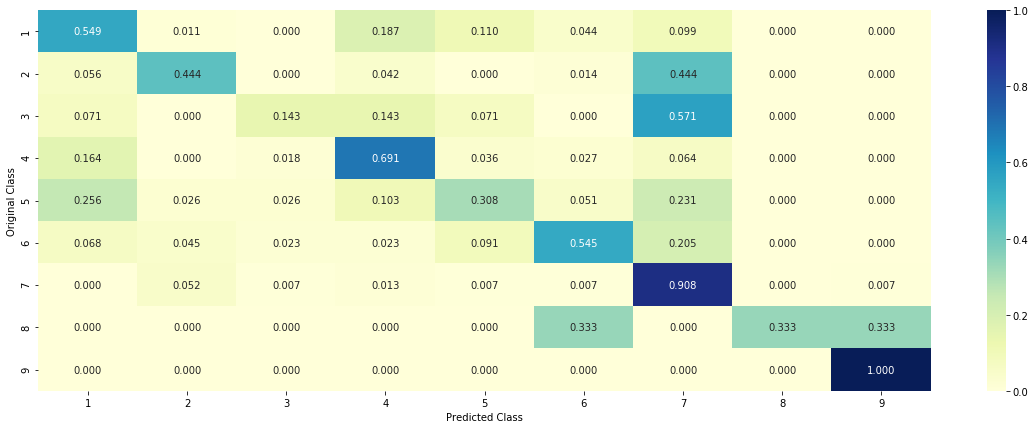

In [102]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, crossval_y, clf)
LR_misclass = mis_class_datapoints(train_x_onehotCoding, train_y, cv_x_onehotCoding, crossval_y, clf)

### Interpretability: Feature Importance

In [103]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulate_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulate_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulate_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulate_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most important features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulate_list, headers=["Index",'Feature name', 'Present or Not']))

### testing one point to check how interpretabble

In [104]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.7519 0.0159 0.0014 0.1939 0.0088 0.0038 0.0204 0.0025 0.0014]]
Actual Class : 1
--------------------------------------------------
414 Text feature [pdgfb] present in test data point [True]
432 Text feature [mixer] present in test data point [True]
459 Text feature [foxh1] present in test data point [True]
486 Text feature [temperature] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [105]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1186 0.5528 0.0013 0.0325 0.0136 0.0066 0.2664 0.0061 0.0021]]
Actual Class : 2
--------------------------------------------------
254 Text feature [comprised] present in test data point [True]
383 Text feature [sbs] present in test data point [True]
409 Text feature [ffpe] present in test data point [True]
465 Text feature [markduplicates] present in test data point [True]
Out of the top  500  features  4 are present in query point


### Results without balancing the classes 

In [106]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(crossval_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(crossval_y, sig_clf_probs)) 


for alpha = 1e-06


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packag

Log Loss : 1.3125207837628312
for alpha = 1e-05
Log Loss : 1.271497898679619
for alpha = 0.0001
Log Loss : 1.1390432784214914
for alpha = 0.001
Log Loss : 1.1336882386022733
for alpha = 0.01
Log Loss : 1.2346754075070323
for alpha = 0.1
Log Loss : 1.3562479068000028
for alpha = 1
Log Loss : 1.5759217732600945


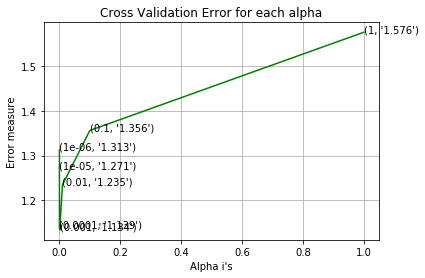

In [107]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [108]:
best_alpha = np.argmin(cv_log_error_array)
LR_notbal_alpha = alpha[best_alpha]
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predicted_y = sig_clf.predict_proba(train_x_onehotCoding)
LR_notbal_train_OH = log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predicted_y, labels=clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(cv_x_onehotCoding)
LR_notbal_cv_OH = log_loss(crossval_y, predicted_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(crossval_y, predicted_y, labels=clf.classes_, eps=1e-15))

predicted_y = sig_clf.predict_proba(test_x_onehotCoding)
LR_notbal_test_OH = log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predicted_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5395553957262307
For values of best alpha =  0.001 The cross validation log loss is: 1.1336882386022733
For values of best alpha =  0.001 The test log loss is: 1.0925951144042134


Log loss : 1.1336882386022733
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


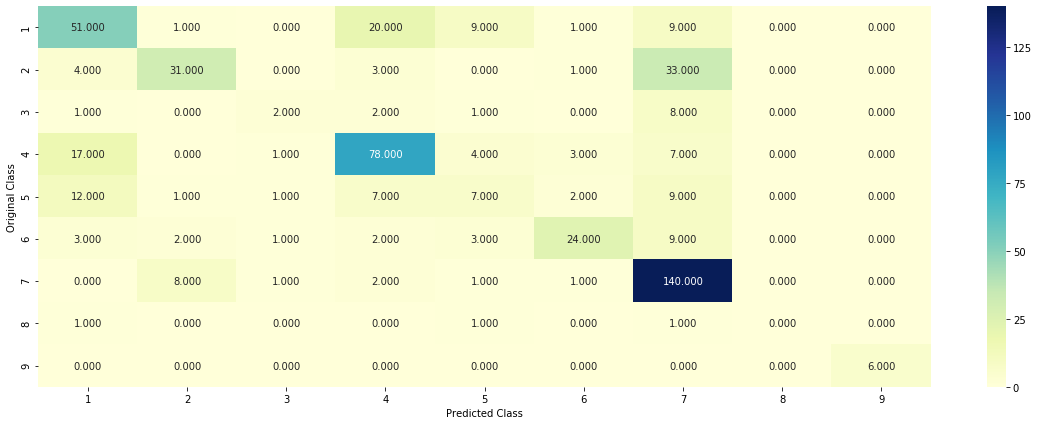

-------------------- Precision matrix (Columm Sum=1) --------------------


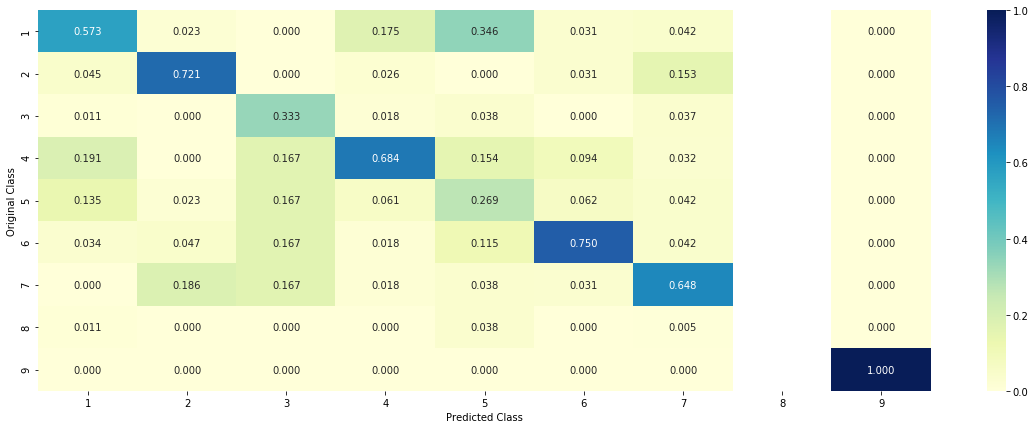

-------------------- Recall matrix (Row sum=1) --------------------


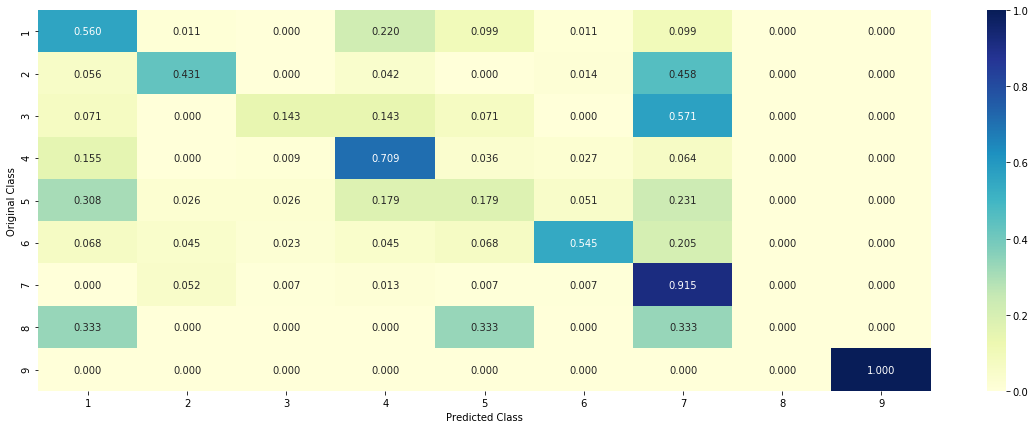

In [109]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, crossval_y, clf)
LR_notbal_misclass = mis_class_datapoints(train_x_onehotCoding, train_y, cv_x_onehotCoding, crossval_y, clf)

### testing a data point

In [110]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[6.810e-01 1.400e-02 8.000e-04 2.716e-01 6.800e-03 2.900e-03 2.160e-02
  1.100e-03 2.000e-04]]
Actual Class : 1
--------------------------------------------------
426 Text feature [pdgfb] present in test data point [True]
Out of the top  500  features  1 are present in query point


# Linear Support Vector Machines

In [111]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(crossval_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(crossval_y, sig_clf_probs)) 


for C = 1e-05


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


Log Loss : 1.330624215082445
for C = 0.0001
Log Loss : 1.2571635606373426
for C = 0.001
Log Loss : 1.1516827649900647
for C = 0.01
Log Loss : 1.153857876277436
for C = 0.1
Log Loss : 1.3894935830029964
for C = 1
Log Loss : 1.7204263243921671
for C = 10
Log Loss : 1.7348914735245238
for C = 100
Log Loss : 1.7348917243896436


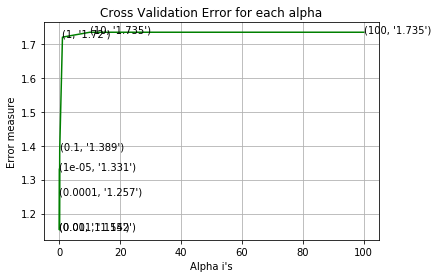

In [112]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [115]:
best_alpha = np.argmin(cv_log_error_array)
SVM_alpha = alpha[best_alpha]
#clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)

clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
SVM_train_OH = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
SVM_cv_OH = log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",
      log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
SVM_test_OH = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5531217858991659
For values of best alpha =  0.001 The cross validation log loss is: 1.1516827649900647
For values of best alpha =  0.001 The test log loss is: 1.1342055866158494


Log loss : 1.1516827649900647
Number of mis-classified points : 0.34962406015037595
-------------------- Confusion matrix --------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


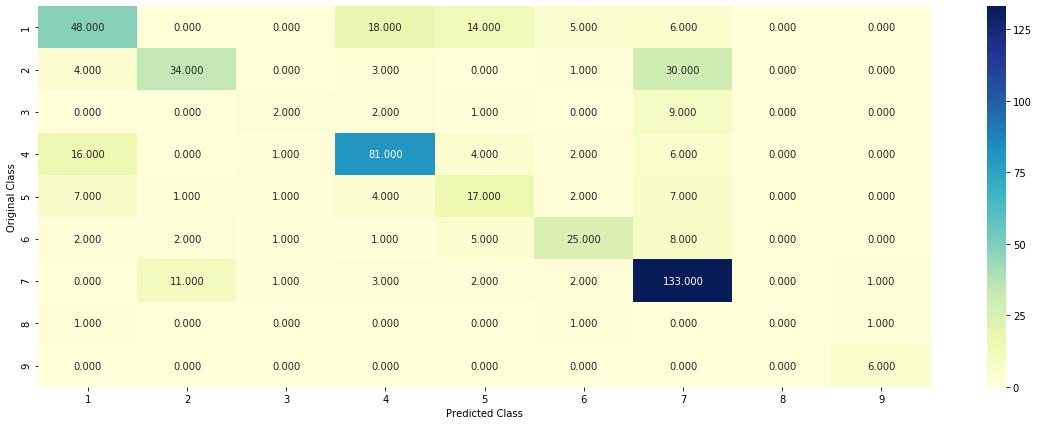

-------------------- Precision matrix (Columm Sum=1) --------------------


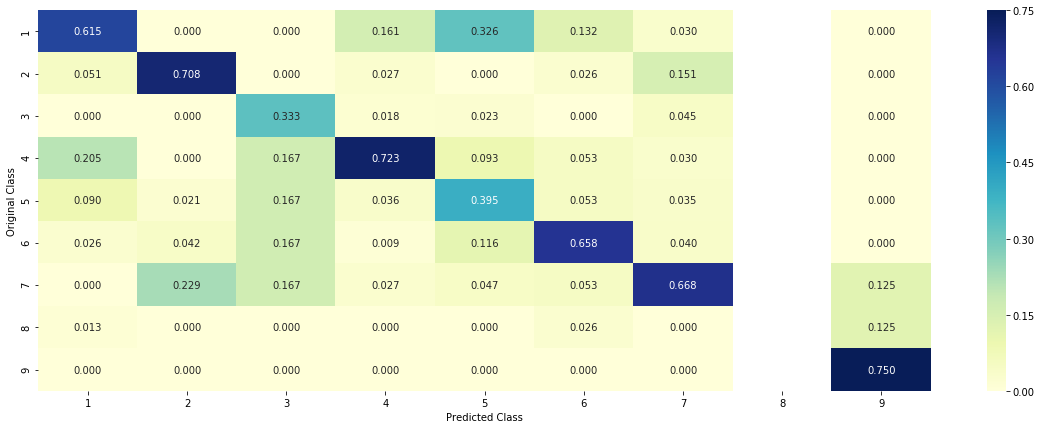

-------------------- Recall matrix (Row sum=1) --------------------


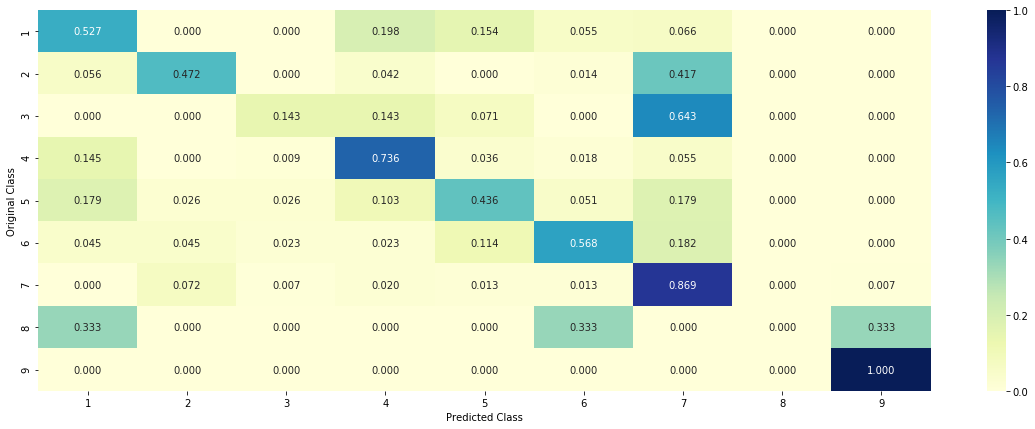

In [116]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,crossval_y, clf)
SVM_misclass = mis_class_datapoints(train_x_onehotCoding, train_y,cv_x_onehotCoding,crossval_y, clf)

In [117]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.7799 0.0349 0.0098 0.0676 0.0366 0.0132 0.0507 0.0034 0.004 ]]
Actual Class : 1
--------------------------------------------------
437 Text feature [foxh1] present in test data point [True]
476 Text feature [mixer] present in test data point [True]
488 Text feature [interfaces] present in test data point [True]
Out of the top  500  features  3 are present in query point


# Random Forest Classifier

### Using One-hot Encoding

In [118]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(crossval_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(crossval_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.2787095928722432
for n_estimators = 100 and max depth =  10
Log Loss : 1.2117976649146374
for n_estimators = 200 and max depth =  5
Log Loss : 1.2572784153152161
for n_estimators = 200 and max depth =  10
Log Loss : 1.1940033540381207
for n_estimators = 500 and max depth =  5
Log Loss : 1.2505135057774932
for n_estimators = 500 and max depth =  10
Log Loss : 1.1842623000944221
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2469344067383836
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1790711174175106
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2457387311173642
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1778353793312841


In [119]:
best_alpha = np.argmin(cv_log_error_array)
RF_alpha_OH = alpha[int(best_alpha/2)]
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)],
                             random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
RF_train_OH = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
RF_cv_OH = log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",
      log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
RF_test_OH = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.7024610187755936
For values of best estimator =  2000 The cross validation log loss is: 1.1778353793312841
For values of best estimator =  2000 The test log loss is: 1.144902497916048


Log loss : 1.1778353793312841
Number of mis-classified points : 0.38721804511278196
-------------------- Confusion matrix --------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


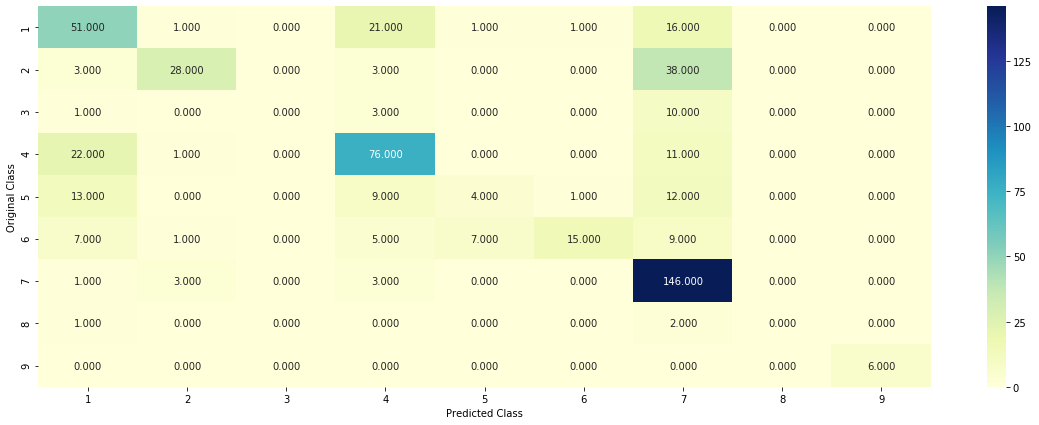

-------------------- Precision matrix (Columm Sum=1) --------------------


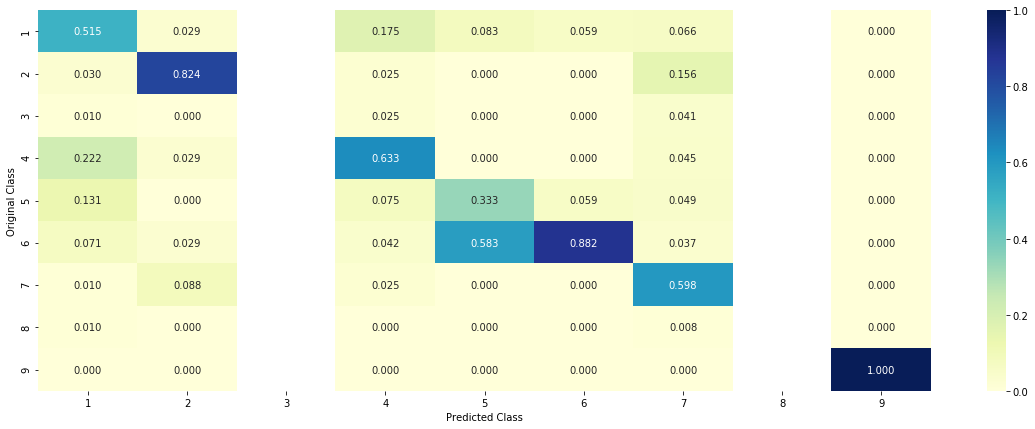

-------------------- Recall matrix (Row sum=1) --------------------


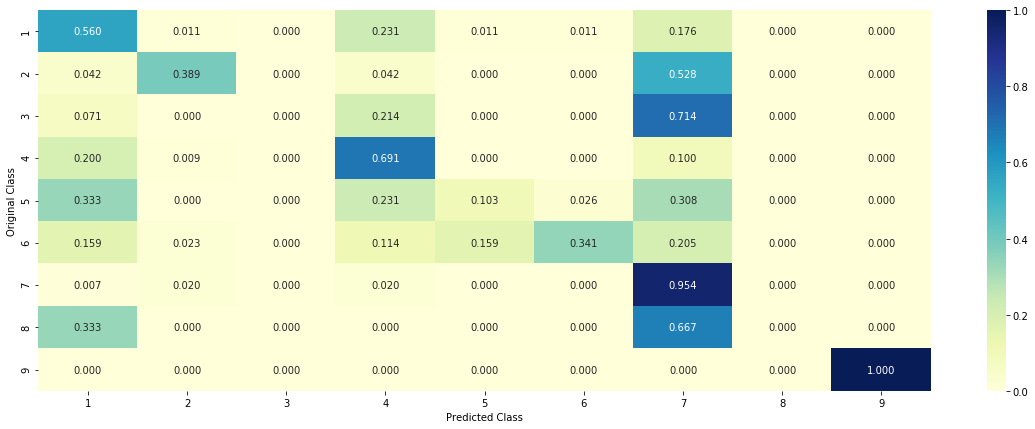

In [120]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)],
                             random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,crossval_y, clf)
RF_OH_misclass = mis_class_datapoints(train_x_onehotCoding, train_y,cv_x_onehotCoding,crossval_y, clf)

In [121]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], x_test['TEXT'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4484 0.0666 0.0208 0.2109 0.0536 0.0461 0.1402 0.006  0.0074]]
Actual Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [phosphorylation] present in test data point [True]
7 Text feature [activated] present in test data point [True]
9 Text feature [signaling] present in test data point [True]
11 Text feature [inhibitor] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feature [treatment] present in test data point [True]
16 Text feature [loss] present in test data point [True]
20 Text feature [growth] present in test data point [True]
21 Text feature [expressing] present in test data point [True]
23 Text feature [ki

### RF with response encoding


### This one is a disaster and suffers from enourmous overfitting

In [129]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(crossval_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(crossval_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(crossval_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1158795263624466
for n_estimators = 10 and max depth =  3
Log Loss : 1.8011373084306237
for n_estimators = 10 and max depth =  5
Log Loss : 1.578765532133454
for n_estimators = 10 and max depth =  10
Log Loss : 1.8072475537545023
for n_estimators = 50 and max depth =  2
Log Loss : 1.8004536560372495
for n_estimators = 50 and max depth =  3
Log Loss : 1.5203773960236413
for n_estimators = 50 and max depth =  5
Log Loss : 1.4597125699751243
for n_estimators = 50 and max depth =  10
Log Loss : 1.6441330613252731
for n_estimators = 100 and max depth =  2
Log Loss : 1.591872320718256
for n_estimators = 100 and max depth =  3
Log Loss : 1.5616027531699552
for n_estimators = 100 and max depth =  5
Log Loss : 1.3920584372234692
for n_estimators = 100 and max depth =  10
Log Loss : 1.6019788173394536
for n_estimators = 200 and max depth =  2
Log Loss : 1.686065592764855
for n_estimators = 200 and max depth =  3
Log Loss : 1.5854006474489672


In [127]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

IndexError: list index out of range

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%2)], n_estimators=alpha[int(best_alpha/2)],
                             criterion='gini', max_features='auto', random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,crossval_y, clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini',
                             max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

# Stacking model
### this works best for large data sets wich is not this particular case but, it doesn't hurt to give it a go

In [134]:
from sklearn.linear_model import LogisticRegression
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(crossval_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(crossval_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(crossval_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(crossval_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(crossval_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.13
Support vector machines : Log Loss: 1.72
Naive Bayes : Log Loss: 1.28
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.037
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.526
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.161
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.285
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.605


Log loss (train) on the stacking classifier : 0.6281782163409177
Log loss (CV) on the stacking classifier : 1.1613263502931521
Log loss (test) on the stacking classifier : 1.1145295697767033
Number of missclassified point : 0.33383458646616543
-------------------- Confusion matrix --------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


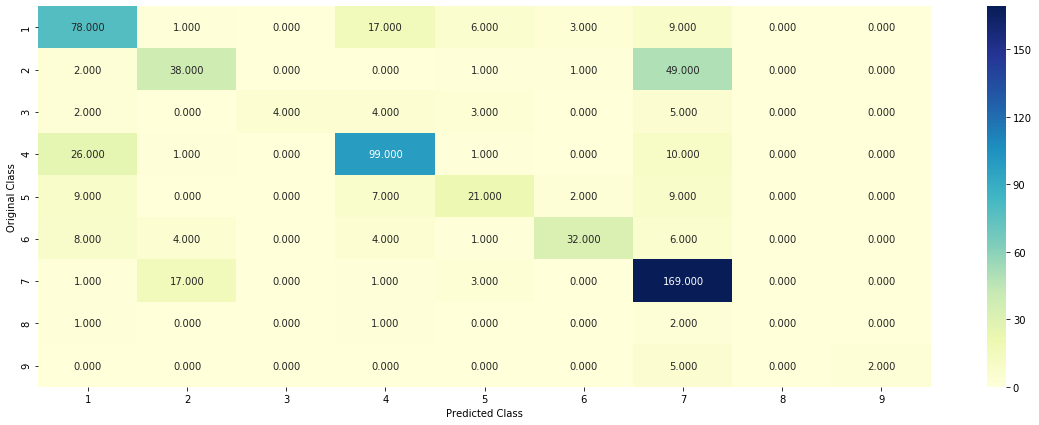

-------------------- Precision matrix (Columm Sum=1) --------------------


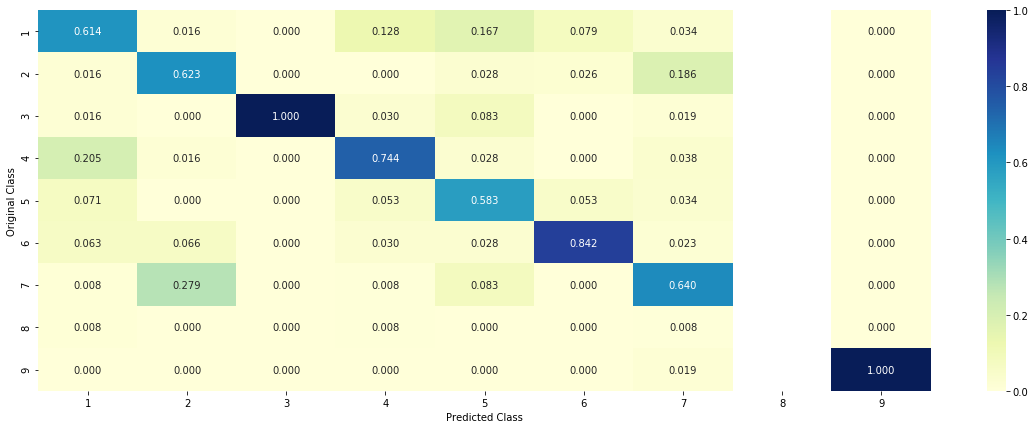

-------------------- Recall matrix (Row sum=1) --------------------


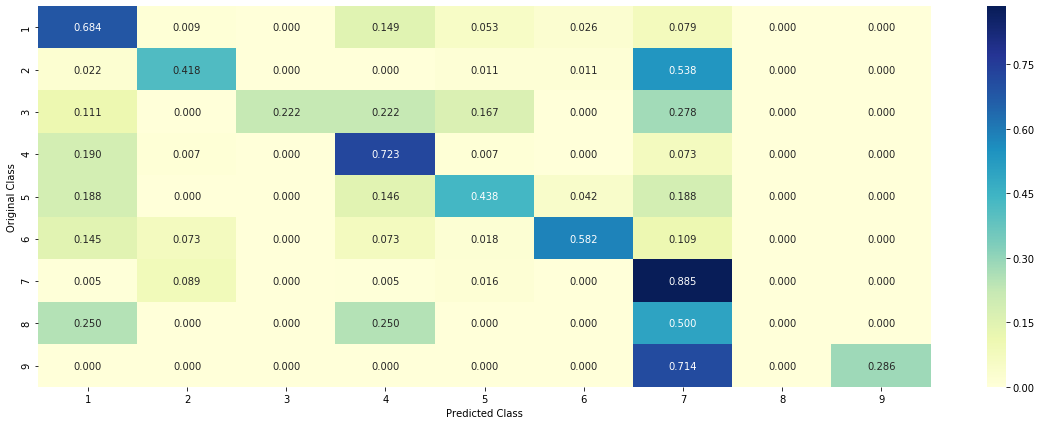

In [136]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
Stack_train = log_error
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(crossval_y, sclf.predict_proba(cv_x_onehotCoding))
Stack_cv = log_error
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
Stack_test = log_error
print("Log loss (test) on the stacking classifier :",log_error)

Stack_misclass = np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0]
print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, sclf.predict(test_x_onehotCoding))

# Maximum voting classifier
#### run them all, choose the best

Log loss (train) on the VotingClassifier : 0.8765463479655592
Log loss (CV) on the VotingClassifier : 1.2184703809720239
Log loss (test) on the VotingClassifier : 1.19051819070709
Number of missclassified point : 0.3458646616541353
-------------------- Confusion matrix --------------------


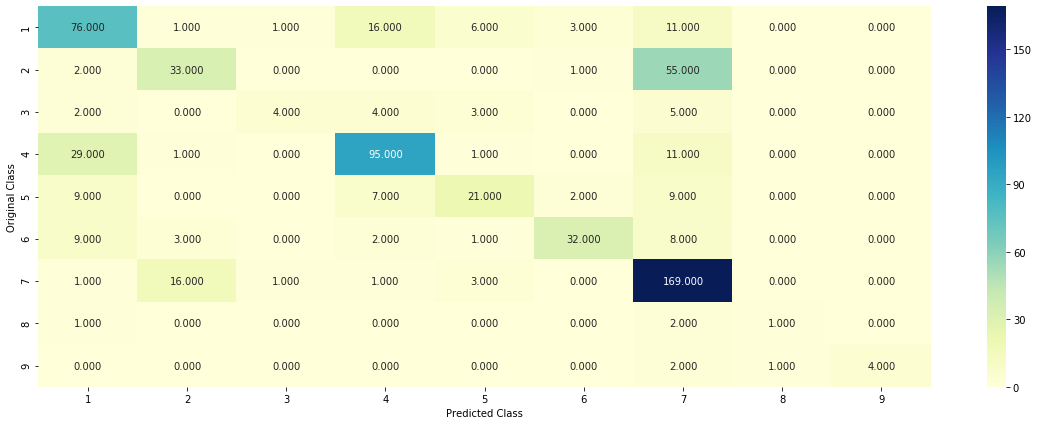

-------------------- Precision matrix (Columm Sum=1) --------------------


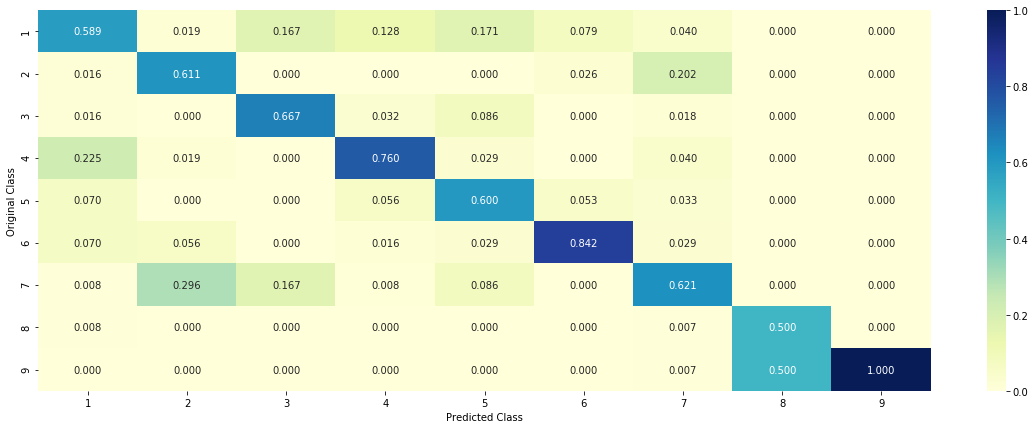

-------------------- Recall matrix (Row sum=1) --------------------


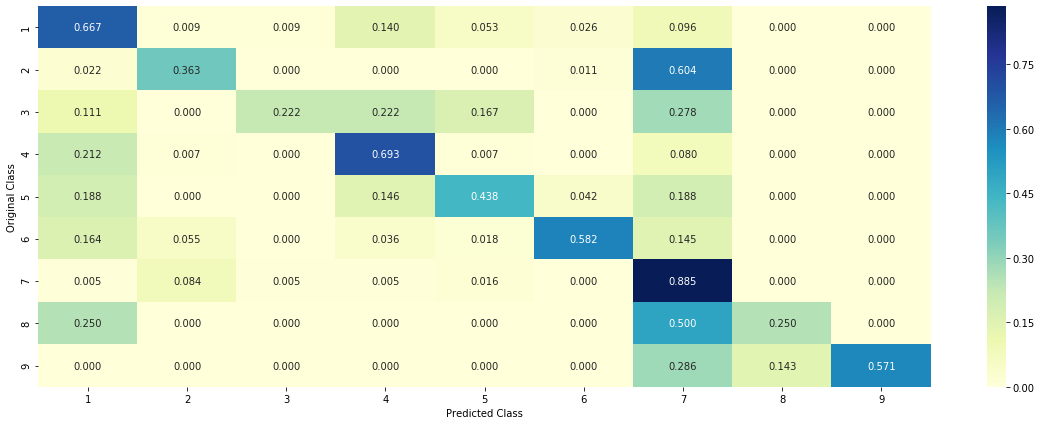

In [139]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
Max_voting_train = log_loss(train_y, vclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))

Max_voting_cv = log_loss(crossval_y, vclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the VotingClassifier :", log_loss(crossval_y, vclf.predict_proba(cv_x_onehotCoding)))

Max_voting_test = log_loss(test_y, vclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))

Max_voting_misclass = np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0]
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, vclf.predict(test_x_onehotCoding))

# Summary table for all the models

In [140]:
summary_table = {'Model' : ['Naive Bayes-OH', 'KNN-RE', 'Log Reg-Bal', 'Log Reg-NBal', 'Linear SVM', 'Rando Forest-OH', 'Stacking Model', 
                           'Maximum v class'], 
                 'Best-a' : [nb_alpha, knn_alpha, LR_bal_alpha, LR_notbal_alpha, SVM_alpha, RF_alpha_OH, 'not applied', 'not applied' ], 
                 'Train LL' : [nb_train_ll_OH, knn_train_ll_RE, LR_bal_train_ll_OH, LR_notbal_train_OH, SVM_train_OH, RF_train_OH, Stack_train, Max_voting_train],
                'Test LL' : [nb_test_ll_OH, knn_test_ll_RE, LR_bal_test_ll_OH, LR_notbal_test_OH, SVM_test_OH, RF_test_OH, Stack_test, Max_voting_test], 
                 'CV LL' : [nb_cv_ll_OH, knn_cv_ll_RE, LR_bal_cv_ll_OH, LR_notbal_cv_OH, SVM_cv_OH, RF_cv_OH, Stack_cv, Max_voting_cv], 
                 'Misclassified' : [nb_misclass_OH, knn_misclass, LR_misclass, LR_notbal_misclass, SVM_misclass, RF_OH_misclass, Stack_misclass, Max_voting_misclass]}  

sum_tab_df = pd.DataFrame(summary_table)

print(sum_tab_df)

             Model       Best-a  Train LL   Test LL     CV LL  Misclassified
0   Naive Bayes-OH       0.0001  0.819958  1.262899  1.279212       0.400376
1           KNN-RE           15  0.715750  1.050031  1.094761       0.409774
2      Log Reg-Bal        0.001  0.543198  1.067986  1.125479       0.357143
3     Log Reg-NBal        0.001  0.539555  1.092595  1.133688       0.362782
4       Linear SVM        0.001  0.553122  1.134206  1.151683       0.349624
5  Rando Forest-OH         2000  0.702461  1.144902  1.177835       0.387218
6   Stacking Model  not applied  0.628178  1.114530  1.161326       0.333835
7  Maximum v class  not applied  0.876546  1.190518  1.218470       0.345865


### In the end I would say that the best models would be the ones with the lower log-losses like the logistic regressions that are the best models for this data set.